In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import required Libraries

In [47]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

##### Ignoring Warnings

In [7]:
import warnings
warnings.filterwarnings('ignore')

Import modules

In [8]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from logger import Logger

In [9]:
# Initialize logger
logger = Logger("userEngagement.log").get_app_logger()
logger.info("Initialized user_experience logger")

#### Import the Data

In [10]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')

In [11]:
df = df_org.copy()

In [12]:
pl = Plot()
overview = Overview(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   bearer_id                                 150001 non-null  float64
 1   start                                     150001 non-null  object 
 2   start_ms                                  150001 non-null  float64
 3   end                                       150001 non-null  object 
 4   end_ms                                    150001 non-null  float64
 5   dur._(ms)                                 150001 non-null  float64
 6   imsi                                      150001 non-null  float64
 7   msisdn/number                             150001 non-null  float64
 8   imei                                      150001 non-null  float64
 9   last_location_name                        150001 non-null  object 
 10  avg_rtt_dl_(ms)     

All missing values have been handled

<AxesSubplot:xlabel='avg_rtt_dl_(ms)'>

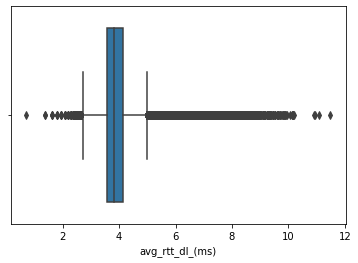

In [14]:
plt.figure(figsize=(6, 4))
sns.boxplot(df['avg_rtt_dl_(ms)'], orient='vert')

>> Aggregate, per customer
        - Average TCP retransmission
        - Average RTT
        - Handset type
        - Average throughput

In [15]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


Get the total transimissions for each customer

In [16]:
user_experience = df[[
    "msisdn/number",
    "avg_rtt_dl_(ms)",
    "avg_rtt_ul_(ms)",
    "avg_bearer_tp_dl_(kbps)",
    "avg_bearer_tp_ul_(kbps)",
    "tcp_dl_retrans._vol_(bytes)",
    "tcp_ul_retrans._vol_(bytes)",
    "handset_type"]]

user_experience['avg_rtt_total'] = user_experience['avg_rtt_dl_(ms)'] + user_experience['avg_rtt_ul_(ms)']
user_experience['avg_bearer_tp_total'] = user_experience['avg_bearer_tp_dl_(kbps)'] + user_experience['avg_bearer_tp_ul_(kbps)']
user_experience['avg_tcp_retrans_total'] = user_experience['tcp_dl_retrans._vol_(bytes)'] + user_experience['tcp_ul_retrans._vol_(bytes)']

In [17]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,0.584435,0.456609,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,1.041044
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,0.584435,0.456609,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,1.041044
2,3.376063e+10,3.806662,1.609438,1.791759,2.197225,0.584435,0.456609,Samsung Galaxy A8 (2018),5.416100,3.988984,1.041044
3,3.375034e+10,3.806662,1.609438,3.784190,3.784190,0.584435,0.456609,undefined,5.416100,7.568379,1.041044
4,3.369980e+10,3.806662,1.609438,1.791759,2.197225,0.584435,0.456609,Samsung Sm-G390F,5.416100,3.988984,1.041044


In [18]:
user_experience_agg = user_experience.groupby('msisdn/number').agg({
    'avg_rtt_total': 'sum',
    'avg_bearer_tp_total': 'sum',
    'avg_tcp_retrans_total': 'sum',
    'handset_type': [lambda x: x.mode()[0]]})

user_experience_df = pd.DataFrame()

user_experience_df["avg_rtt_total"] = user_experience_agg["avg_rtt_total"]['sum']
user_experience_df["avg_tp_total"] = user_experience_agg["avg_bearer_tp_total"]['sum']
user_experience_df["total_avg_tcp_total"] = user_experience_agg["avg_tcp_retrans_total"]['sum']
user_experience_df["handset_type"] = user_experience_agg["handset_type"]['<lambda>']
user_experience_df.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,-inf,7.274480,1.041044,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,1.041044,Apple iPhone 7 (A1778)
3.360100e+10,5.416100,7.763021,1.041044,undefined
3.360101e+10,6.942157,9.102310,0.748804,Apple iPhone 5S (A1457)
3.360101e+10,-inf,27.135851,2.212931,Apple iPhone Se (A1723)


>> ##### Compute & list 10 of the top, bottom and most frequent:

In [19]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,0.584435,0.456609,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,1.041044
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,0.584435,0.456609,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,1.041044
2,3.376063e+10,3.806662,1.609438,1.791759,2.197225,0.584435,0.456609,Samsung Galaxy A8 (2018),5.416100,3.988984,1.041044
3,3.375034e+10,3.806662,1.609438,3.784190,3.784190,0.584435,0.456609,undefined,5.416100,7.568379,1.041044
4,3.369980e+10,3.806662,1.609438,1.791759,2.197225,0.584435,0.456609,Samsung Sm-G390F,5.416100,3.988984,1.041044


In [20]:
top_10_tcp = user_experience.nlargest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
bottom_10_tcp = user_experience.nsmallest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
most_frequent_tcp = user_experience.value_counts('avg_bearer_tp_total').nlargest(10)


[]

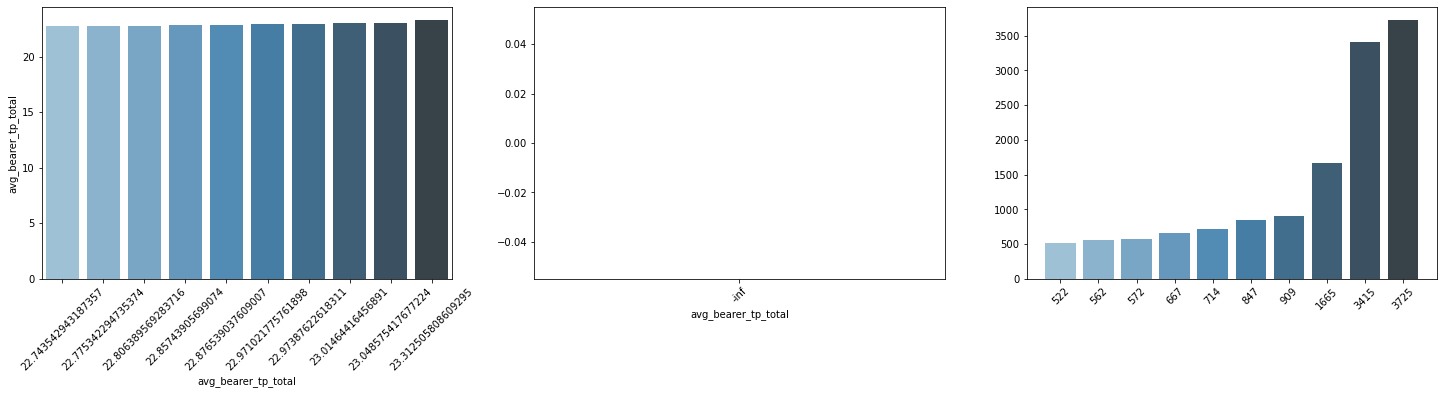

In [21]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_tcp, x=top_10_tcp.index, orient='v', y=top_10_tcp, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_tcp, x=bottom_10_tcp.index,orient='v', y=bottom_10_tcp.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_tcp, x=most_frequent_tcp.index,orient='v', y=most_frequent_tcp.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


RTT VALUES 

[]

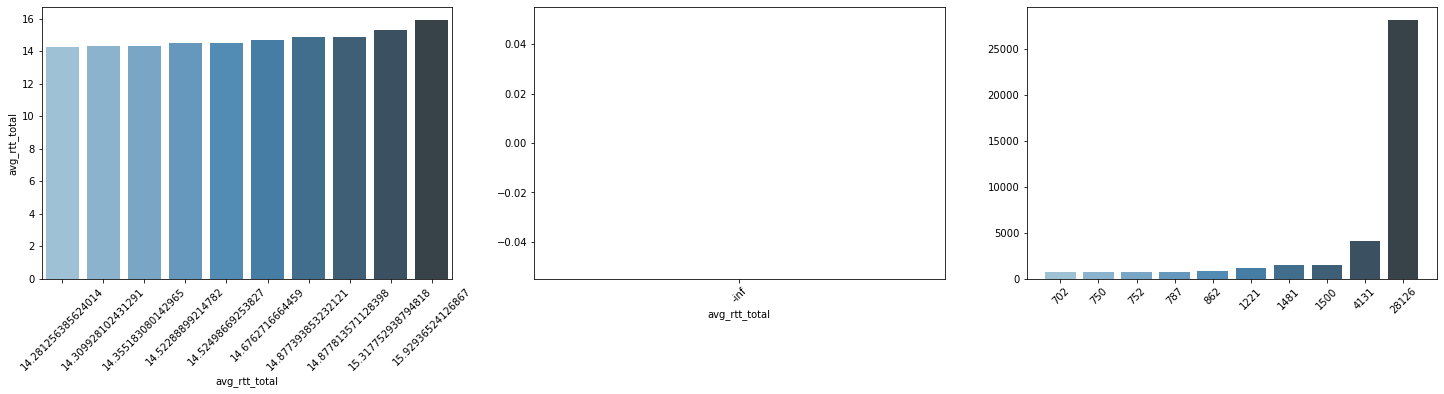

In [22]:
top_10_rtt = user_experience.nlargest(10, 'avg_rtt_total')['avg_rtt_total']
bottom_10_rtt = user_experience.nsmallest(10, 'avg_rtt_total')['avg_rtt_total']
most_frequent_rtt = user_experience.value_counts('avg_rtt_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_rtt, x=top_10_rtt.index, orient='v', y=top_10_rtt, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_rtt, x=bottom_10_rtt.index,orient='v', y=bottom_10_rtt.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_rtt, x=most_frequent_rtt.index,orient='v', y=most_frequent_rtt.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


Throughput values

[]

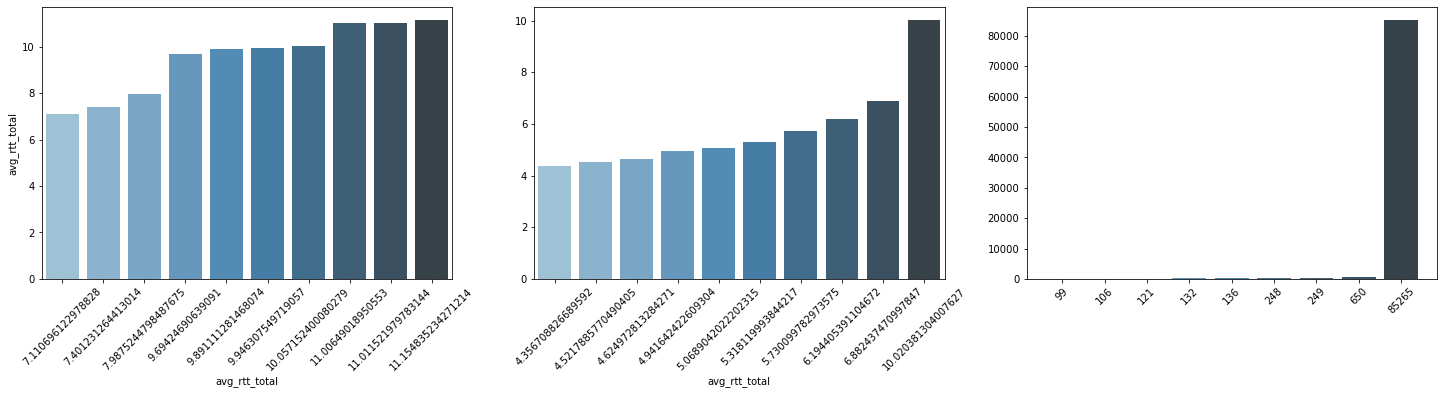

In [23]:
top_10_retrans = user_experience.nlargest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
bottom_10_retrans = user_experience.nsmallest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
most_frequent_retrans = user_experience.value_counts('avg_tcp_retrans_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_retrans, x=top_10_retrans.index, orient='v', y=top_10_retrans, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_retrans, x=bottom_10_retrans.index,orient='v', y=bottom_10_retrans.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_retrans, x=most_frequent_retrans.index,orient='v', y=most_frequent_retrans.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


>> #### The distribution of the average throughput  per handset type and provide interpretation for your findings.


Distribution of the average throughput per handset

In [24]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,0.584435,0.456609,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,1.041044
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,0.584435,0.456609,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,1.041044
2,3.376063e+10,3.806662,1.609438,1.791759,2.197225,0.584435,0.456609,Samsung Galaxy A8 (2018),5.416100,3.988984,1.041044
3,3.375034e+10,3.806662,1.609438,3.784190,3.784190,0.584435,0.456609,undefined,5.416100,7.568379,1.041044
4,3.369980e+10,3.806662,1.609438,1.791759,2.197225,0.584435,0.456609,Samsung Sm-G390F,5.416100,3.988984,1.041044


In [25]:
handset_type_df = user_experience.groupby('handset_type').agg(
    {'avg_bearer_tp_total': 'mean', 'avg_tcp_retrans_total': 'mean'})
handset_type_df.head()

,avg_bearer_tp_total,avg_tcp_retrans_total
handset_type,,
A-Link Telecom I. Cubot A5,15.838115,1.041044
A-Link Telecom I. Cubot Note Plus,13.931197,1.024772
A-Link Telecom I. Cubot Note S,15.094590,1.294047
A-Link Telecom I. Cubot Nova,17.237061,0.847885
A-Link Telecom I. Cubot Power,16.978497,0.636703


Top throughput

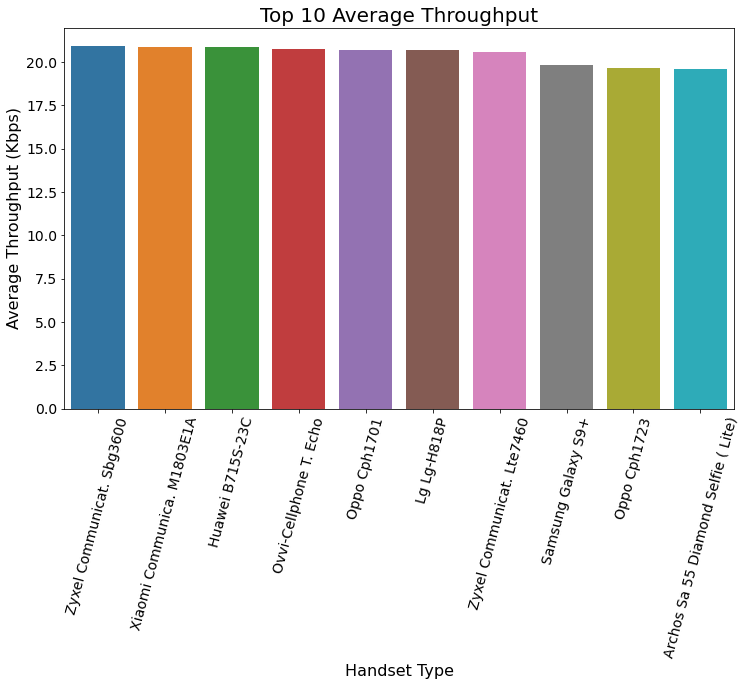

In [26]:
top_tp = handset_type_df.nlargest(10, 'avg_bearer_tp_total')
pl.plot_bar(top_tp ,top_tp.index, top_tp.avg_bearer_tp_total, "Top 10 Average Throughput", "Handset Type", "Average Throughput (Kbps)")

The highest amount of throughput is of the handset type: Zyxel Communicat. Sbg3600, then comes Xiaomi Communica. M1803E1A, followed by the Huawei B715S-23C.

>> The average TCP retransmission view per handset type and provide interpretation for your findings.

Top TCP retransmission

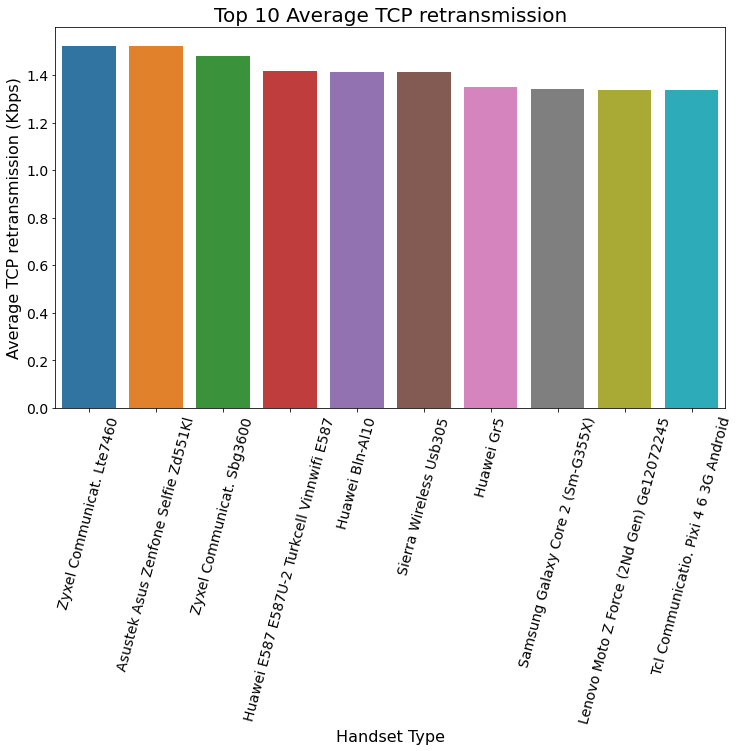

In [27]:
top_tcp = handset_type_df.nlargest(10, 'avg_tcp_retrans_total')
pl.plot_bar(top_tcp ,top_tcp.index, top_tcp.avg_tcp_retrans_total, "Top 10 Average TCP retransmission", "Handset Type", "Average TCP retransmission (Kbps)")

The  Zyxel Communicat. Sbg3600 phones seems to have high throughput as well as highes tcp transmissions

>> #### Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster. (The description must define each group based on your understanding of the data)

In [28]:
user_experience_df.head(2)

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,-inf,7.274480,1.041044,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,1.041044,Apple iPhone 7 (A1778)


In [29]:
# Drop the handset_type column
user_experience = user_experience_df.drop(['handset_type'], axis=1)

In [36]:
#  Replace inf values with null then fill with the column mean
user_experience.replace([np.inf, -np.inf], np.nan, inplace=True)

In [37]:
user_experience.isnull().sum()

avg_rtt_total          0
avg_tp_total           0
total_avg_tcp_total    0
dtype: int64

In [38]:
# replace the missing values with the mean of the column
user_experience = user_experience.fillna(user_experience.mean())

In [46]:
user_experience_df.head(2)

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,-inf,7.274480,1.041044,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,1.041044,Apple iPhone 7 (A1778)


In [48]:
def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data 
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [51]:
normalized_user_experience = normalizer(user_experience, ['avg_rtt_total',	'avg_tp_total',	'total_avg_tcp_total'] )

In [52]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_user_experience)
centroids = kmeans.cluster_centers_

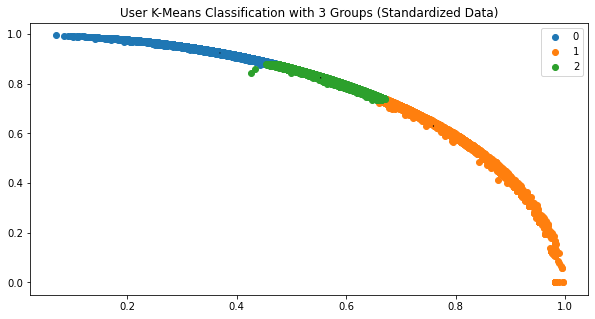

In [54]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_user_experience[label == i].iloc[:,0] , normalized_user_experience[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [55]:
logger.info(f'# Centroids of the clustering:\n{centroids}')
logger.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
logger.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

 Customers that grouped into cluster 0 have higher transmission rate(throughput) and a lower re-transmission meaning that it successfully reaches its destination whcih means that they have a good connection. On the other hand customers grouped into cluster 3 have higher retransmission which means that they have a poor connection. Customers in group 2 has good throuput rate compared to customers in cluster 3.

>> Save the data

In [56]:
user_experience.to_csv('../data/user_experience.csv')